In [1]:
from pathlib import Path

# Asumo que arrancás Jupyter en la raíz del repo: ~/proyectos/betavae-xai-ad
PROJECT_ROOT = Path("/home/diego/proyectos/betavae-xai-ad/").resolve()
print("Project root:", PROJECT_ROOT)

# Elegí el experimento que querés interpretar
RUN = PROJECT_ROOT / "results" / "vae_clf_ad_ld256_beta66_manual"
# Si quisieras el otro:
# RUN = PROJECT_ROOT / "results" / "vae_clf_ad_ld256_beta66_cosinewarm"

GT = PROJECT_ROOT / "data" / "AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned" / \
     "GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"

META = PROJECT_ROOT / "data" / "SubjectsData_AAL3_procesado2.csv"

# Para anotaciones de ROI, lo más natural en este repo es usar:
ANNO = RUN / "roi_info_from_tensor.csv"

print("RUN :", RUN)
print("GT  :", GT)
print("META:", META)
print("ANNO:", ANNO)
print("Existen?:", GT.exists(), META.exists(), ANNO.exists())


Project root: /home/diego/proyectos/betavae-xai-ad
RUN : /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual
GT  : /home/diego/proyectos/betavae-xai-ad/data/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz
META: /home/diego/proyectos/betavae-xai-ad/data/SubjectsData_AAL3_procesado2.csv
ANNO: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/roi_info_from_tensor.csv
Existen?: True True True


In [2]:
!find "{RUN}" -name "shap_pack_mlp.joblib" -print -delete

In [3]:
for f in [1, 2, 3, 4, 5]:
    print(f"=== FOLD {f} :: SHAP (frozen) ===")
    !python "{PROJECT_ROOT / 'scripts' / 'run_interpretability.py'}" shap \
        --run_dir "{RUN}" \
        --fold {f} \
        --clf svm \
        --global_tensor_path "{GT}" \
        --metadata_path "{META}" \
        --channels_to_use 1 2 5 \
        --latent_dim 256 \
        --latent_features_type mu \
        --metadata_features Age Sex \
        --num_conv_layers_encoder 4 \
        --decoder_type convtranspose \
        --dropout_rate_vae 0.2 \
        --intermediate_fc_dim_vae quarter \
        --vae_final_activation tanh \
        --kernel_nsamples 5000 \
        --shap_link logit \
        --bg_mode train --bg_sample_size 100 --bg_seed 42 \
        --freeze_meta Age Sex --freeze_strategy train_stats \
        --shap_normalize by_logit_median \
        --shap_tag frozen


=== FOLD 1 :: SHAP (frozen) ===
[INFO] [SHAP] fold=1 clf=svm
[WARNING] label_mapping.json no encontrado; se asume CN=0 / AD=1
[INFO] [SHAP] META congelado para ['Age', 'Sex'] (train_stats).
[INFO] [SHAP] X_raw (test) shape=(37, 258) (latentes + 2 metadatos)
[INFO] [SHAP] Latentes detectadas en procesado: 256 / 258
[INFO] [SHAP] No hay background RAW. Construyendo con bg_mode=train…
[INFO] [SHAP] Background RAW → shap_background_raw_svm_train_frozen.joblib; PROCESADO → shap_background_proc_svm_train_frozen.joblib
[dtype('float32') dtype('float64') dtype('O')]
[dtype('float64')]
[INFO] [SHAP] Usando shap.Explainer + Independent masker (permutation/interventional).
[INFO] [SHAP] Permutation: F=258, min_required=517, usando max_evals=5000.
PermutationExplainer explainer: 38it [09:15, 15.01s/it]                         
[INFO] [SHAP] SHAP forzados a 0 por ser constantes: ['Age']
[INFO] [SHAP] Normalizado por mediana |f(x)-base| (escala ~logit): factor=0.7302
[INFO] [SHAP] Pack guardado: /ho

In [4]:
for f in [1, 2, 3, 4, 5]:
    print(f"=== FOLD {f} :: SALIENCY (IG, frozen) ===")
    !python "{PROJECT_ROOT / 'scripts' / 'run_interpretability.py'}" saliency \
        --run_dir "{RUN}" \
        --fold {f} \
        --clf svm \
        --global_tensor_path "{GT}" \
        --metadata_path "{META}" \
        --channels_to_use 1 2 5 \
        --latent_dim 256 \
        --latent_features_type mu \
        --metadata_features Age Sex \
        --num_conv_layers_encoder 4 \
        --decoder_type convtranspose \
        --dropout_rate_vae 0.2 \
        --intermediate_fc_dim_vae quarter \
        --vae_final_activation tanh \
        --roi_annotation_path "{ANNO}" \
        --top_k 50 \
        --shap_weight_mode ad_vs_cn_diff \
        --saliency_method integrated_gradients \
        --ig_n_steps 64 \
        --ig_baseline cn_median_train \
        --shap_tag frozen


=== FOLD 1 :: SALIENCY (IG, frozen) ===
[INFO] [SALIENCY] fold=1 clf=svm  (pack cargado: shap_pack_svm_frozen.joblib)
[INFO] Cargado fichero de anotaciones: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/roi_info_from_tensor.csv
[INFO] [SALIENCY] Usando columna 'roi_name_in_tensor' como nombres de ROI.
[INFO] Derivado orden de ROIs desde el CSV de anotaciones.
[INFO] [SALIENCY] 50 latentes ponderadas. Ejemplo:
 latent_idx   weight  importance    feature
         59 0.082681    0.187010  latent_59
        227 0.036274    0.082044 latent_227
          3 0.031933    0.072226   latent_3
         58 0.031249    0.070680  latent_58
         36 0.030187    0.068277  latent_36
[INFO] [SALIENCY] Sujetos AD=19  CN=18
[INFO] [SALIENCY] Usando método de saliencia: integrated_gradients
[INFO] [IG] Baseline: mediana CN del TRAIN del fold (sin fuga de test).
[WARNING] roi_map_df sin columna de índice explícita; se usará el índice 0..N-1 como ROI_TensorIdx (asumiendo orden

In [10]:
# Elegí el experimento que querés interpretar
RUN = PROJECT_ROOT / "results" / "vae_clf_ad_ld256_beta66_manual"
# Si quisieras el otro:
# RUN = PROJECT_ROOT / "results" / "vae_clf_ad_ld256_beta66_cosinewarm"

GT = PROJECT_ROOT / "data" / "AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned" / \
     "GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"

META = PROJECT_ROOT / "data" / "SubjectsData_AAL3_procesado2.csv"

# Corremos SHAP UNFROZEN para los 5 folds
for f in [1, 2, 3, 4, 5]:
    print(f"\n=== FOLD {f} :: SHAP (UNFROZEN) ===")
    !python "{PROJECT_ROOT / 'scripts' / 'run_interpretability.py'}" shap \
        --run_dir "$RUN" \
        --fold $f \
        --clf svm \
        --global_tensor_path "$GT" \
        --metadata_path "$META" \
        --channels_to_use 1 2 5 \
        --latent_dim 256 \
        --latent_features_type mu \
        --metadata_features Age Sex \
        --num_conv_layers_encoder 4 \
        --decoder_type convtranspose \
        --dropout_rate_vae 0.2 \
        --intermediate_fc_dim_vae quarter \
        --vae_final_activation tanh \
        --kernel_nsamples 5000 \
        --shap_link logit \
        --bg_mode train --bg_sample_size 100 --bg_seed 42 \
        --shap_normalize by_logit_median \
        --shap_tag unfrozen


=== FOLD 1 :: SHAP (UNFROZEN) ===
[INFO] [SHAP] fold=1 clf=svm
[WARNING] label_mapping.json no encontrado; se asume CN=0 / AD=1
[INFO] [SHAP] X_raw (test) shape=(37, 258) (latentes + 2 metadatos)
[INFO] [SHAP] Latentes detectadas en procesado: 256 / 258
[INFO] [SHAP] No hay background RAW. Construyendo con bg_mode=train…
[INFO] [SHAP] Background RAW → shap_background_raw_svm_train_unfrozen.joblib; PROCESADO → shap_background_proc_svm_train_unfrozen.joblib
[dtype('float32') dtype('float64') dtype('O')]
[dtype('float64')]
[INFO] [SHAP] Usando shap.Explainer + Independent masker (permutation/interventional).
[INFO] [SHAP] Permutation: F=258, min_required=517, usando max_evals=5000.
PermutationExplainer explainer: 38it [10:05, 16.37s/it]                         
[INFO] [SHAP] Normalizado por mediana |f(x)-base| (escala ~logit): factor=0.7532
[INFO] [SHAP] Pack guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/fold_1/interpretability_shap/shap_pack_svm_u

In [11]:
# compare_freeze.py
from pathlib import Path
import joblib, numpy as np, pandas as pd, re

# Configuración
RUN_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual")
CLF = "svm"  # Usaste SVM en el último paso

rows = []
for f in range(1, 6):
    d = RUN_DIR / f"fold_{f}" / "interpretability_shap"
    
    # Cargar ambos packs
    path_frozen = d / f"shap_pack_{CLF}_frozen.joblib"
    path_unfrozen = d / f"shap_pack_{CLF}_unfrozen.joblib"
    
    if path_frozen.exists() and path_unfrozen.exists():
        pf = joblib.load(path_frozen)
        pu = joblib.load(path_unfrozen)
        
        # Usar máscara para filtrar solo latentes (ignorar Age/Sex en la correlación)
        mask = np.array(pf['latent_feature_mask'], bool)
        
        # Calcular media de valor absoluto de SHAP por feature
        mf = np.abs(pf['shap_values']).mean(axis=0)[mask]
        mu = np.abs(pu['shap_values']).mean(axis=0)[mask]
        
        # Correlación de Pearson
        r = np.corrcoef(mf, mu)[0, 1]
        rows.append({'fold': f, 'pearson_r': float(r)})

# Guardar y mostrar
df_corr = pd.DataFrame(rows)
df_corr.to_csv(RUN_DIR / f"compare_{CLF}_frozen_unfrozen.csv", index=False)
print("Correlación SHAP Latentes (Frozen vs Unfrozen):")
print(df_corr)

Correlación SHAP Latentes (Frozen vs Unfrozen):
   fold  pearson_r
0     1   0.948446
1     2   0.981757
2     3   0.993568
3     4   0.996811
4     5   0.993204


In [12]:
# global_ranking.py
import pandas as pd
import numpy as np
import joblib
import re

RUN_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual")
CLF = "svm"

all_ranks = []

def prettify(n):
    if re.search(r'(?:^|__)Age\b', n): return "Age"
    if re.search(r'(?:^|__)Sex\b', n): return "Sex"
    m = re.search(r'latent_(\d+)', n)
    return f"Latent {m.group(1)}" if m else n

for f in range(1, 6):
    # Usamos 'unfrozen' para ver el impacto real de todo (incluido Age/Sex)
    p = RUN_DIR / f"fold_{f}" / "interpretability_shap" / f"shap_pack_{CLF}_unfrozen.joblib"
    if p.exists():
        pack = joblib.load(p)
        S = np.abs(np.asarray(pack["shap_values"], float)).mean(axis=0)
        names = list(map(str, pack["feature_names"]))
        
        df = pd.DataFrame({"feature": names, "shap_abs": S})
        df["pretty_name"] = df["feature"].map(prettify)
        df["fold"] = f
        all_ranks.append(df)

# Consolidar
df_all = pd.concat(all_ranks)
df_summary = (df_all.groupby("pretty_name")
              .agg(mean_shap=("shap_abs", "mean"), std_shap=("shap_abs", "std"))
              .sort_values("mean_shap", ascending=False)
              .reset_index())

print("Top 20 Features más importantes (Global):")
print(df_summary.head(20))
df_summary.to_csv(RUN_DIR / "global_feature_importance_summary.csv", index=False)

Top 20 Features más importantes (Global):
   pretty_name  mean_shap  std_shap
0          Age   0.719735  0.073723
1          Sex   0.072318  0.020246
2   Latent 162   0.047528  0.005983
3   Latent 188   0.043559  0.031626
4    Latent 59   0.041556  0.044269
5    Latent 77   0.038638  0.015123
6   Latent 114   0.038416  0.016735
7    Latent 27   0.037802  0.023437
8    Latent 80   0.036160  0.019035
9     Latent 6   0.035509  0.022722
10   Latent 54   0.035503  0.024642
11   Latent 76   0.035012  0.020462
12  Latent 205   0.034024  0.019413
13  Latent 196   0.033820  0.025130
14  Latent 156   0.033729  0.021353
15  Latent 216   0.033634  0.010428
16   Latent 43   0.032553  0.016623
17   Latent 57   0.032390  0.016086
18  Latent 194   0.031947  0.030461
19  Latent 212   0.031680  0.013179


Matriz de consenso guardada en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/consensus_saliency_matrix.png


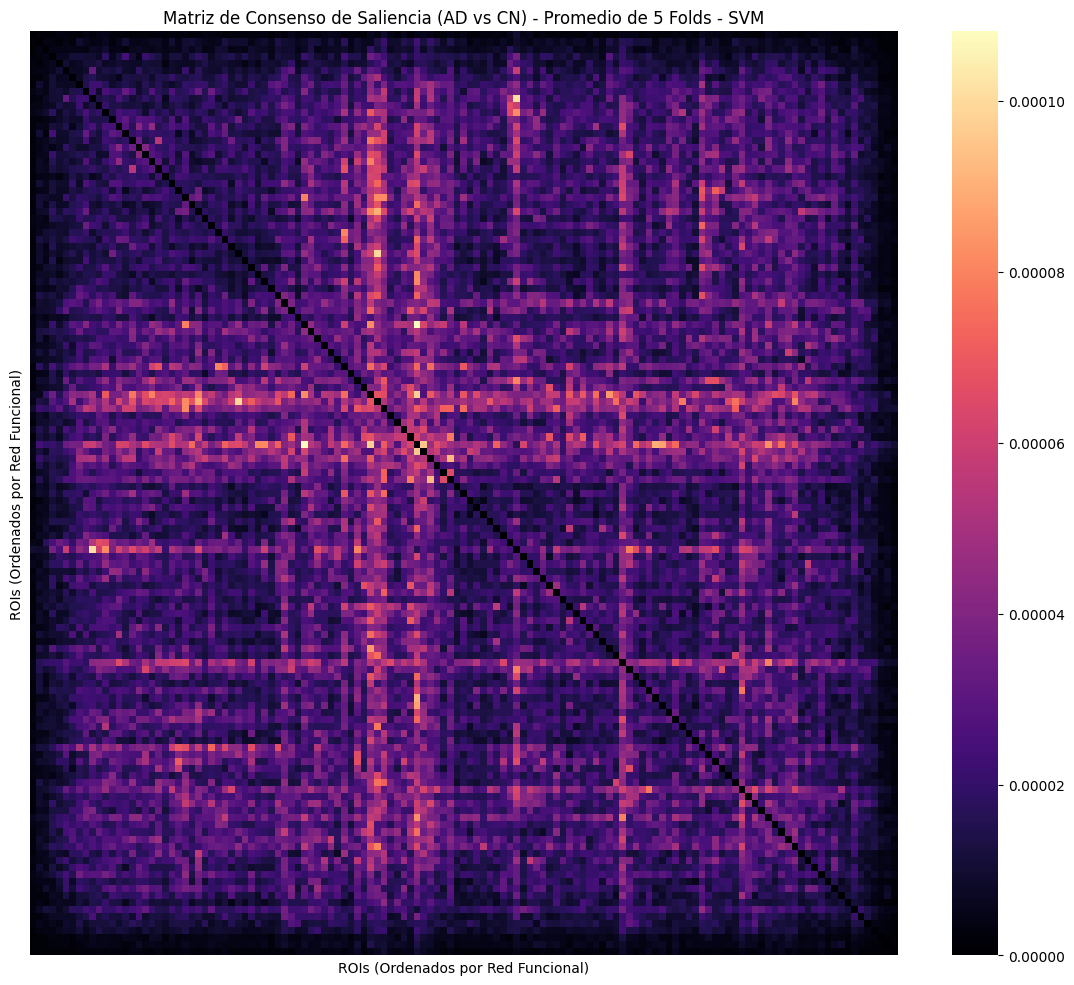

In [13]:
# consensus_matrix.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RUN_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual")
CLF = "svm"

# 1. Cargar las matrices de saliencia (diferencia absoluta) de todos los folds
matrices = []
for f in range(1, 6):
    p = RUN_DIR / f"fold_{f}" / f"interpretability_{CLF}" / f"saliency_map_diff_abs_integrated_gradients_top50.npy"
    if p.exists():
        # El archivo guardado es (C, R, R) o (R, R) dependiendo de cómo se guardó.
        # Normalmente tu script guarda (C, R, R). Hacemos media sobre canales.
        sal = np.load(p)
        if sal.ndim == 3:
            sal = sal.mean(axis=0)
        matrices.append(sal)

if matrices:
    # 2. Calcular promedio
    consensus_matrix = np.mean(matrices, axis=0)
    
    # 3. Cargar nombres de ROIs para ejes (usamos el archivo generado en el run)
    roi_info = pd.read_csv(RUN_DIR / "roi_info_from_tensor.csv")
    roi_names = roi_info['roi_name_in_tensor'].values
    
    # 4. Plotear
    plt.figure(figsize=(14, 12))
    sns.heatmap(consensus_matrix, cmap="magma", xticklabels=False, yticklabels=False)
    plt.title(f"Matriz de Consenso de Saliencia (AD vs CN) - Promedio de 5 Folds - {CLF.upper()}")
    plt.xlabel("ROIs (Ordenados por Red Funcional)")
    plt.ylabel("ROIs (Ordenados por Red Funcional)")
    
    # Guardar
    out_path = RUN_DIR / "consensus_saliency_matrix.png"
    plt.savefig(out_path, dpi=300)
    print(f"Matriz de consenso guardada en: {out_path}")
    plt.show()
else:
    print("No se encontraron archivos de saliencia.")

In [23]:
# Celda 1 — Helpers globales para análisis SHAP/IG (SVM, beta66_manual)

from pathlib import Path
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.collections


# Ruta del proyecto / experimento (coherente con la primera parte del notebook)
PROJECT_ROOT = Path("/home/diego/proyectos/betavae-xai-ad/").resolve()
RUN_DIR = PROJECT_ROOT / "results" / "vae_clf_ad_ld256_beta66_manual"
CLF = "svm"
FOLDS = [1, 2, 3, 4, 5]

print("RUN_DIR:", RUN_DIR)

def prettify_feature(name: str) -> str:
    """Nombre amigable para tablas/plots (Age, Sex, latent_k)."""
    if re.search(r'(?:^|__)Age\b', name):
        return "Age"
    if re.search(r'(?:^|__)Sex\b', name):
        return "Sex"
    m = re.search(r'latent_(\d+)', name)
    if m:
        return f"latent {m.group(1)}"
    return name

def load_shap_pack(run_dir: Path, fold: int, clf: str, tag: str):
    """
    Carga shap_pack_<clf>_<tag>.joblib del fold dado.
    tag ∈ {'frozen','unfrozen'} en este notebook.
    """
    p = run_dir / f"fold_{fold}" / "interpretability_shap" / f"shap_pack_{clf}_{tag}.joblib"
    if not p.exists():
        raise FileNotFoundError(f"No existe: {p}")
    return joblib.load(p)

def ajustar_opacidad_violin(alpha: float = 0.35, subir_puntos: bool = True, ax=None):
    """
    Baja la opacidad de violines en shap.summary_plot y resalta el beeswarm.
    """
    ax = ax or plt.gca()
    for pc in ax.findobj(mpl.collections.PolyCollection):
        pc.set_alpha(alpha)
    for p in ax.patches:
        try:
            p.set_alpha(alpha)
        except Exception:
            pass
    if subir_puntos:
        for sc in ax.findobj(mpl.collections.PathCollection):
            sc.set_zorder(3)
            sc.set_edgecolor("white")
            sc.set_linewidth(0.4)

def save_multi(base_path: Path, dpi: int = 300):
    """
    Guarda la figura actual en PNG / SVG / PDF usando base_path sin extensión.
    """
    base_path = Path(base_path)
    for ext in (".png", ".svg", ".pdf"):
        out = base_path.with_suffix(ext)
        plt.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Guardado:", base_path.with_suffix(".png"), "(+ svg/pdf)")


RUN_DIR: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual


In [24]:
# Celda 2 — Importancia de latentes (FROZEN) por fold y consenso global

rows_per_fold = []
all_rows = []

for f in FOLDS:
    pack = load_shap_pack(RUN_DIR, f, CLF, tag="frozen")
    shap_vals = np.asarray(pack["shap_values"], float)   # (N,F)
    featnames = list(map(str, pack["feature_names"]))

    latent_mask = np.array([re.search(r'(?:^|__)latent_\d+\b', n) is not None
                            for n in featnames])
    if not latent_mask.any():
        raise RuntimeError(f"Fold {f}: no se detectaron columnas latentes en feature_names.")

    shap_lat = shap_vals[:, latent_mask]
    names_lat = np.array(featnames)[latent_mask]
    mean_abs = np.abs(shap_lat).mean(axis=0)

    df_fold = (pd.DataFrame({
                    "feature": names_lat,
                    "pretty_feature": [prettify_feature(n) for n in names_lat],
                    "mean_abs_shap": mean_abs,
                    "fold": f
               })
               .sort_values("mean_abs_shap", ascending=False)
               .reset_index(drop=True))

    rows_per_fold.append(df_fold)

    out_fold = RUN_DIR / f"fold_{f}" / "interpretability_shap" / f"fold{f}_latent_importance_FROZEN.csv"
    df_fold.to_csv(out_fold, index=False)
    print(f"Fold {f}: guardado ranking de latentes en {out_fold.name}")

    all_rows.append(df_fold)

df_all = pd.concat(all_rows, ignore_index=True)

df_global = (df_all
             .groupby(["feature", "pretty_feature"], as_index=False)
             .agg(mean_abs_shap_across_folds=("mean_abs_shap", "mean"),
                  std_abs_shap_across_folds=("mean_abs_shap", "std"),
                  n_folds=("fold", "nunique"))
             .sort_values("mean_abs_shap_across_folds", ascending=False))

out_global = RUN_DIR / "latent_importance_across_folds_FROZEN.csv"
df_global.to_csv(out_global, index=False)
print("\n✅ Guardado consenso de latentes (FROZEN):", out_global)
display(df_global.head(20))


Fold 1: guardado ranking de latentes en fold1_latent_importance_FROZEN.csv
Fold 2: guardado ranking de latentes en fold2_latent_importance_FROZEN.csv
Fold 3: guardado ranking de latentes en fold3_latent_importance_FROZEN.csv
Fold 4: guardado ranking de latentes en fold4_latent_importance_FROZEN.csv
Fold 5: guardado ranking de latentes en fold5_latent_importance_FROZEN.csv

✅ Guardado consenso de latentes (FROZEN): /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/latent_importance_across_folds_FROZEN.csv


,feature,pretty_feature,mean_abs_shap_across_folds,std_abs_shap_across_folds,n_folds
211,latent_59,latent 59,0.043861,0.048860,5
18,latent_114,latent 114,0.042167,0.019737,5
99,latent_188,latent 188,0.041204,0.032660,5
71,latent_162,latent 162,0.039445,0.003173,5
176,latent_27,latent 27,0.038126,0.025691,5
212,latent_6,latent 6,0.035948,0.022371,5
235,latent_80,latent 80,0.035550,0.022136,5
206,latent_54,latent 54,0.035425,0.026369,5
231,latent_77,latent 77,0.035191,0.011804,5
230,latent_76,latent 76,0.034106,0.020108,5


Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/fold_1/interpretability_shap/fold1_shap_top20_UNFROZEN_violin.png (+ svg/pdf)


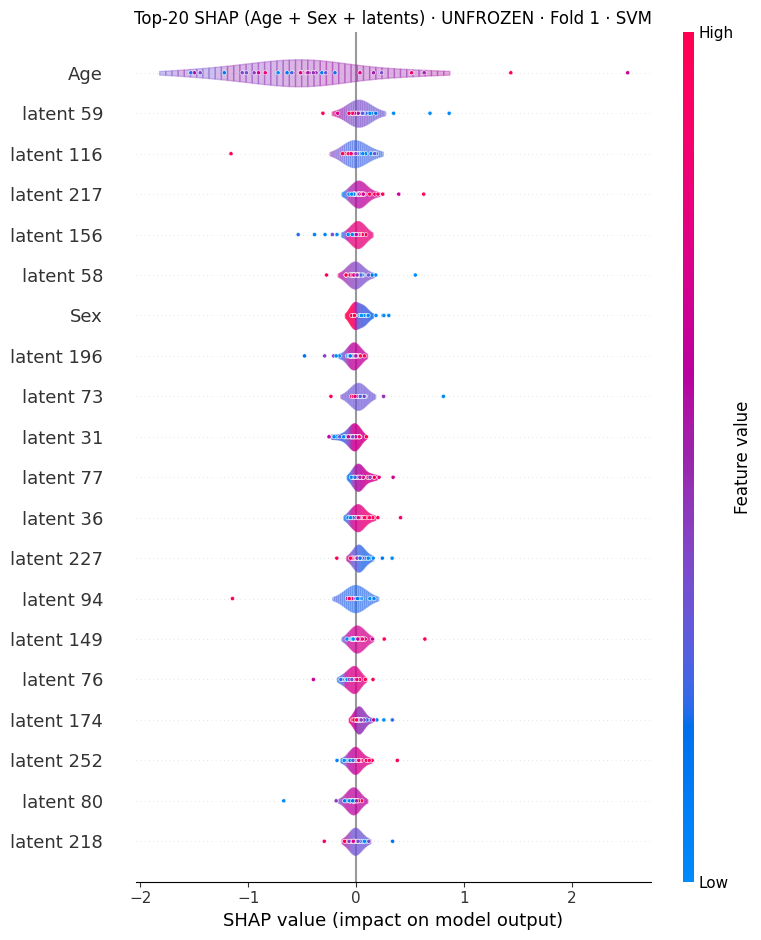

Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/fold_2/interpretability_shap/fold2_shap_top20_UNFROZEN_violin.png (+ svg/pdf)


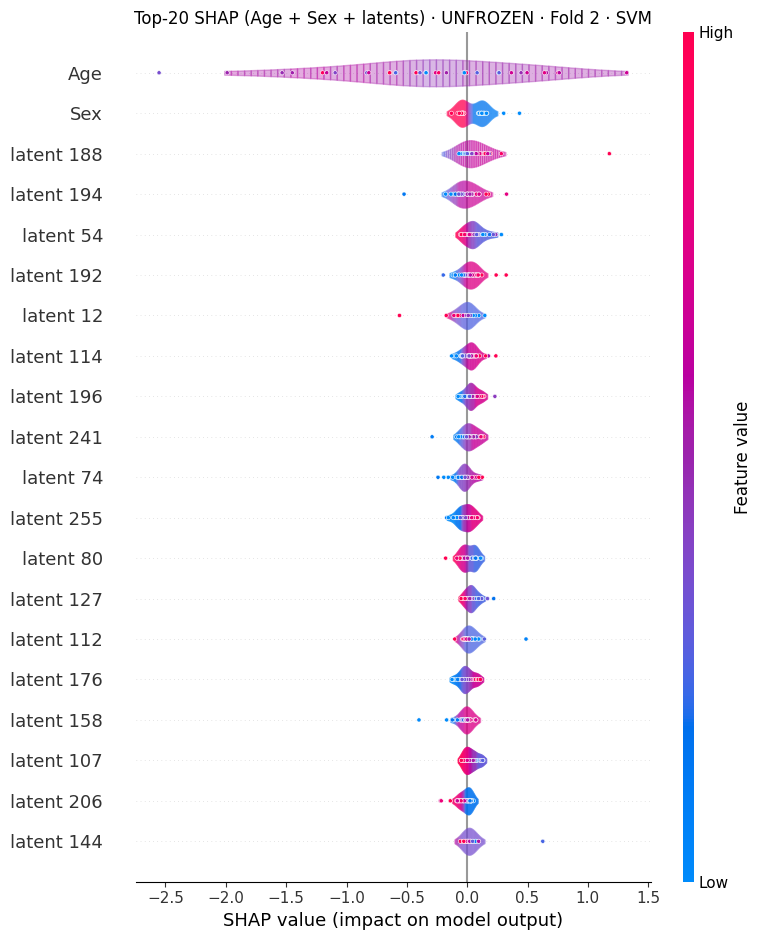

Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/fold_3/interpretability_shap/fold3_shap_top20_UNFROZEN_violin.png (+ svg/pdf)


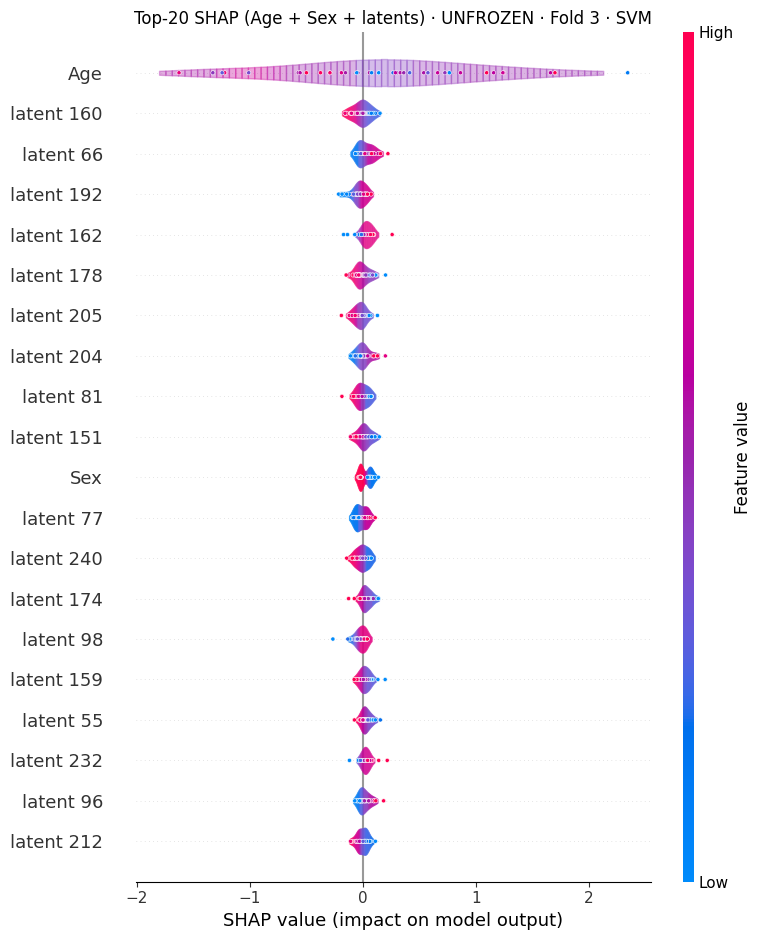

Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/fold_4/interpretability_shap/fold4_shap_top20_UNFROZEN_violin.png (+ svg/pdf)


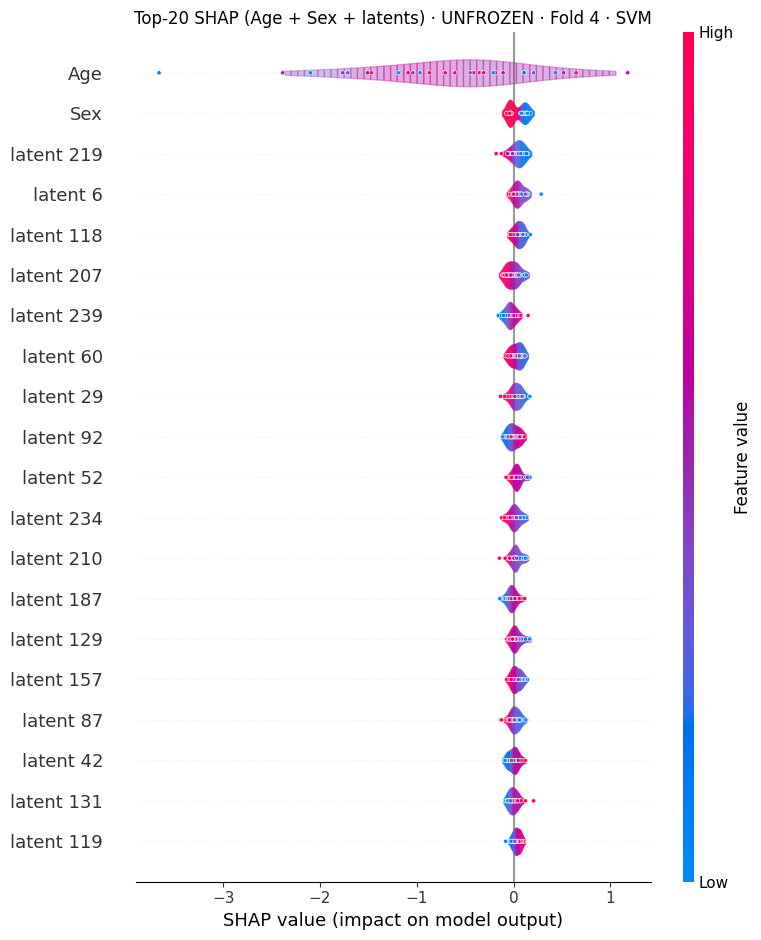

Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/fold_5/interpretability_shap/fold5_shap_top20_UNFROZEN_violin.png (+ svg/pdf)


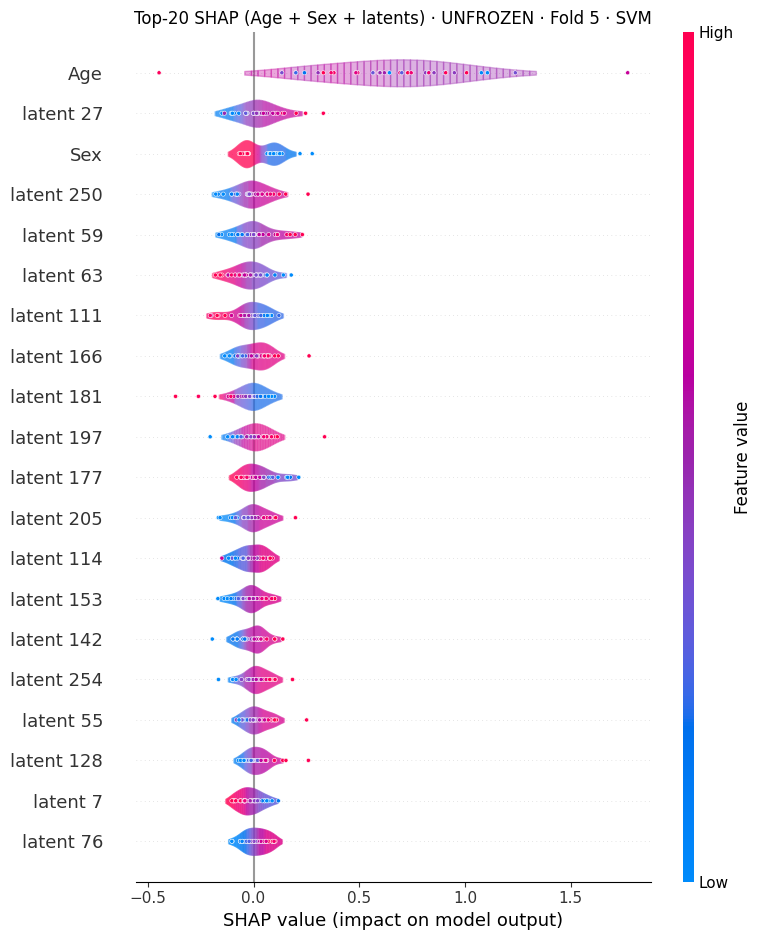

In [25]:
# Celda 3 — SHAP UNFROZEN: Top-20 features (Age, Sex, latentes) por fold

TOPK = 20

for f in FOLDS:
    pack = load_shap_pack(RUN_DIR, f, CLF, tag="unfrozen")
    shap_vals = np.asarray(pack["shap_values"], float)
    Xtest = pack["X_test"]
    featnames = list(map(str, pack["feature_names"]))

    mean_abs = np.abs(shap_vals).mean(axis=0)
    order = np.argsort(mean_abs)[::-1][:TOPK]

    S_top = shap_vals[:, order]
    X_top = Xtest.iloc[:, order]
    pretty = [prettify_feature(featnames[i]) for i in order]

    plt.figure(figsize=(8, 6))
    shap.summary_plot(
        S_top,
        X_top,
        feature_names=pretty,
        max_display=TOPK,
        plot_type="violin",
        show=False
    )
    ajustar_opacidad_violin(alpha=0.35)

    plt.title(f"Top-{TOPK} SHAP (Age + Sex + latents) · UNFROZEN · Fold {f} · {CLF.upper()}")
    plt.tight_layout()

    out_base = RUN_DIR / f"fold_{f}" / "interpretability_shap" / f"fold{f}_shap_top{TOPK}_UNFROZEN_violin"
    save_multi(out_base)
    plt.show()
    plt.close()


Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/interpretability_shap/shap_Age_UNFROZEN_allfolds.png (+ svg/pdf)


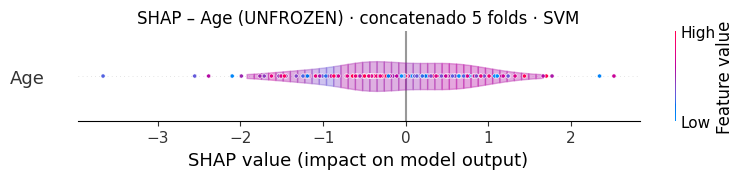

In [26]:
# Celda 4 — SHAP UNFROZEN: Age agregada en los 5 folds

EPS = 1e-6

def summary_plot_single_safe(shap_vals_1d, x_1d, featname: str, title: str, out_base: Path):
    """
    summary_plot para una sola feature, con pequeño jitter si X es casi constante.
    """
    s = np.asarray(shap_vals_1d, float).reshape(-1, 1)
    x = np.asarray(x_1d, float).reshape(-1, 1)

    if np.nanstd(x) < EPS:
        rng = np.random.default_rng(42)
        x = x + rng.normal(0.0, EPS, size=x.shape)

    df_x = pd.DataFrame({featname: x.ravel()})

    plt.figure(figsize=(7.5, 4.0))
    shap.summary_plot(
        s,
        df_x,
        feature_names=[featname],
        plot_type="violin",
        show=False,
        max_display=1,
        sort=False
    )
    ajustar_opacidad_violin(alpha=0.35)
    plt.title(title)
    plt.tight_layout()
    save_multi(out_base)
    plt.show()
    plt.close()

# Recolectar Age y sus SHAP en todos los folds de forma UNFROZEN
all_shap_age = []
all_age = []
for f in FOLDS:
    pack = load_shap_pack(RUN_DIR, f, CLF, tag="unfrozen")
    shap_vals = np.asarray(pack["shap_values"], float)
    Xtest = pack["X_test"]
    featnames = list(map(str, pack["feature_names"]))

    age_idx = [i for i, n in enumerate(featnames)
               if re.search(r'(?:^|__)Age\b', n)]
    if not age_idx:
        print(f"Fold {f}: 'Age' no encontrado, se omite.")
        continue
    i = age_idx[0]
    all_shap_age.append(shap_vals[:, i])
    all_age.append(np.asarray(Xtest.iloc[:, i], float))

if not all_shap_age:
    print("No se encontró Age en ningún fold.")
else:
    s_age = np.concatenate(all_shap_age, axis=0)
    x_age = np.concatenate(all_age, axis=0)

    out_dir = RUN_DIR / "interpretability_shap"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_base = out_dir / "shap_Age_UNFROZEN_allfolds"

    summary_plot_single_safe(
        s_age,
        x_age,
        featname="Age",
        title=f"SHAP – Age (UNFROZEN) · concatenado 5 folds · {CLF.upper()}",
        out_base=out_base
    )


In [27]:
# Celda 5 — Consenso de edges salientes (IG, SVM, top-50 latentes por fold)

import itertools

TAG = "integrated_gradients_top50"
clf = CLF  # alias

edge_dfs = []
edge_sets_top = []
TOP_EDGES_PER_FOLD = 200  # para el Jaccard; ajustalo si querés

def edge_key_df(df: pd.DataFrame) -> pd.Series:
    """Clave de arista no dirigida a partir de nombres de AAL3."""
    a = df["src_AAL3_Name"].astype(str)
    b = df["dst_AAL3_Name"].astype(str)
    return pd.DataFrame({"a": a, "b": b}).apply(
        lambda r: tuple(sorted((r["a"], r["b"]))),
        axis=1
    )

for f in FOLDS:
    csv_path = RUN_DIR / f"fold_{f}" / f"interpretability_{clf}" / f"ranking_conexiones_ANOTADO_{TAG}.csv"
    if not csv_path.exists():
        print(f"Fold {f}: no encontré {csv_path.name}, se omite.")
        continue

    df = pd.read_csv(csv_path)
    df["edge_key"] = edge_key_df(df)
    df["fold"] = f
    edge_dfs.append(df)

    topK = df.head(TOP_EDGES_PER_FOLD)
    edge_sets_top.append(set(topK["edge_key"]))

if not edge_dfs:
    print("No se encontró ningún ranking_conexiones_ANOTADO_...; revisá rutas.")
else:
    # Jaccard promedio entre folds para los top-K
    jaccs = []
    for (i, s_i), (j, s_j) in itertools.combinations(enumerate(edge_sets_top), 2):
        inter = len(s_i & s_j)
        union = len(s_i | s_j)
        j = inter / union if union else 0.0
        jaccs.append(j)
    if jaccs:
        print(f"Mean Jaccard (top-{TOP_EDGES_PER_FOLD} edges por fold): {np.mean(jaccs):.3f}")

    # Consenso global: frecuencia y saliencia media
    df_all_edges = pd.concat(edge_dfs, ignore_index=True)

    gb = (df_all_edges
          .groupby("edge_key", as_index=False)
          .agg(freq=("fold", "nunique"),
               Saliency_Abs_mean=("Saliency_Abs", "mean"),
               Saliency_Signed_mean=("Saliency_Signed", "mean"),
               src_name=("src_AAL3_Name", "first"),
               dst_name=("dst_AAL3_Name", "first"),
               src_network=("src_Refined_Network", "first"),
               dst_network=("dst_Refined_Network", "first"))
          .sort_values(["freq", "Saliency_Abs_mean"], ascending=[False, False]))

    out_edges = RUN_DIR / f"consensus_edges_{clf}_{TAG}.csv"
    gb.to_csv(out_edges, index=False)
    print("✅ Guardado consenso de edges en:", out_edges)

    display(gb.head(25))


Mean Jaccard (top-200 edges por fold): 0.034
✅ Guardado consenso de edges en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/consensus_edges_svm_integrated_gradients_top50.csv


,edge_key,freq,Saliency_Abs_mean,Saliency_Signed_mean,src_name,dst_name,src_network,dst_network
6277,"(OFCant_R, Temporal_Inf_L)",5,0.000108,-0.000027,Temporal_Inf_L,OFCant_R,Limbic_A_TempPole,Limbic_B_OFC
3899,"(Cingulate_Post_L, Occipital_Sup_R)",5,0.000101,-0.000085,Occipital_Sup_R,Cingulate_Post_L,Visual_Peripheral,DefaultMode_Core
5892,"(Insula_L, OFClat_L)",5,0.000100,0.000075,Insula_L,OFClat_L,Salience_VentralAttention_A,Limbic_B_OFC
6169,"(OFCant_L, OFCant_R)",5,0.000097,-0.000058,OFCant_L,OFCant_R,Limbic_B_OFC,Limbic_B_OFC
6238,"(OFCant_R, OFClat_R)",5,0.000096,0.000015,OFCant_R,OFClat_R,Limbic_B_OFC,Limbic_B_OFC
6528,"(OFCmed_R, Rectus_R)",5,0.000092,0.000021,OFCmed_R,Rectus_R,Limbic_B_OFC,Limbic_B_OFC
2882,"(Cerebelum_8_L, OFCant_R)",5,0.000090,-0.000019,OFCant_R,Cerebelum_8_L,Limbic_B_OFC,Background/NonCortical
6352,"(OFClat_L, Temporal_Sup_R)",5,0.000090,0.000041,Temporal_Sup_R,OFClat_L,Somatomotor_B,Limbic_B_OFC
3091,"(Cerebelum_9_L, OFCant_R)",5,0.000087,0.000037,OFCant_R,Cerebelum_9_L,Limbic_B_OFC,Background/NonCortical
6213,"(OFCant_L, Temporal_Mid_R)",5,0.000084,-0.000067,OFCant_L,Temporal_Mid_R,Limbic_B_OFC,DefaultMode_VentralMedial


In [28]:
# Celda 6 — Consenso de aporte por canal (IG, SVM, top-50 latentes)

rows = []
TAG = "integrated_gradients_top50"
clf = CLF

for f in FOLDS:
    csv_path = RUN_DIR / f"fold_{f}" / f"interpretability_{clf}" / f"channel_contributions_{TAG}.csv"
    if not csv_path.exists():
        print(f"Fold {f}: no encontré {csv_path.name}, se omite.")
        continue
    df = pd.read_csv(csv_path)
    df["fold"] = f
    rows.append(df)

if not rows:
    print("No se encontraron archivos channel_contributions_*.csv.")
else:
    df_all = pd.concat(rows, ignore_index=True)

    g = (df_all
         .groupby(["channel_index_used", "channel_name"], as_index=False)
         .agg(frac_mean=("l1_norm_fraction_abs", "mean"),
              frac_std=("l1_norm_fraction_abs", "std"),
              n_folds=("fold", "nunique"))
         .sort_values("frac_mean", ascending=False))

    out_chan = RUN_DIR / f"channels_consensus_{clf}_{TAG}.csv"
    g.to_csv(out_chan, index=False)
    print("✅ Guardado consenso de canales en:", out_chan)

    display(g)


✅ Guardado consenso de canales en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual/channels_consensus_svm_integrated_gradients_top50.csv


,channel_index_used,channel_name,frac_mean,frac_std,n_folds
0,1,Ch1,0.390685,0.020100,5
1,2,Ch2,0.375357,0.030333,5
2,5,Ch5,0.233958,0.023339,5
